In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
from tqdm import tqdm
import pylab as pl
from IPython import display
from master.imgaug.imgaug import augmenters as iaa

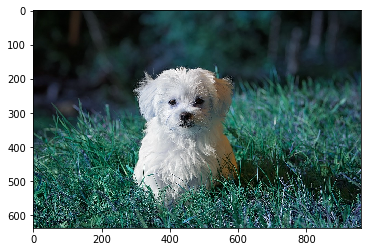

In [3]:
import cv2
%matplotlib inline
image = cv2.imread('dog.jpg')
plt.imshow(image)

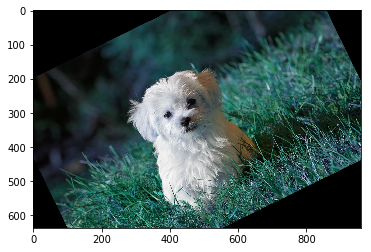

In [12]:
img = image
tl = iaa.Affine(rotate=(-60,60))
img = tl.augment_image(img)
plt.imshow(img)

In [13]:
data_path = "cifar/"

In [14]:
def load_CIFAR_batch(filename):
    try:
       with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding='bytes')
            X = datadict[b'data']
            Y = datadict[b'labels']
#             X = (X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float"))*-1
            X = (X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float"))
            Y = np.array(Y)
            return X,Y
    except EOFError:
        return {}

In [15]:
def load_data(path):
    xs = []
    ys = []
    for i in tqdm(range(1,6)):
        f = os.path.join(path, 'data_batch_%d' %( i, ) )
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    X_tr = np.concatenate(xs)
    Y_tr = np.concatenate(ys)
    del X, Y
    X_te , Y_te = load_CIFAR_batch(os.path.join(path, 'test_batch'))
    return X_tr, Y_tr, X_te, Y_te

In [16]:
X_tr, Y_tr, X_te, Y_te = load_data(data_path)

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


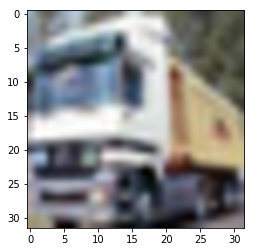

In [17]:
plt.imshow((X_tr[1])/255,interpolation='spline16')
plt.show()

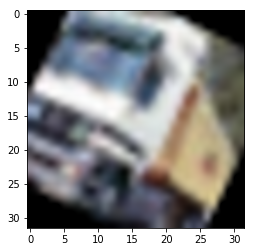

In [18]:
img = X_tr[1]
tl = iaa.Affine(rotate=(-60,60))
img = tl.augment_image(img)
plt.imshow(img/255, interpolation='spline16')

In [19]:
# image = cv2.fromarray(X_tr[1])
# dropout = iaa.Dropout(0.3)
# imgg = (dropout.augment_image(image))
# plt.imshow(imgg)

In [37]:
def augmentor(images,labels):
    
    aug_images =[]
    for image in tqdm(images):
        aug_images.append(image)
        
#         vflipper = iaa.Flipud(1.0) # vertically flip each input image with 90% probability
#         aug_images.append(vflipper.augment_image(image)) # probably vertically flip image 1
        
#         rotater =iaa.Affine(shear=(-50, 30)) #not working. Color gets distorted
#         images = rotater.augment_image(image)
#         aug_images.append(images)

#         croper = iaa.Crop(percent=(0., 0.2)) #not working. Color gets distorted
#         images = croper.augment_image(image)
#         aug_images.append(images)

#         vflipper = iaa.Flipud(1.0) # vertically flip each input image with 90% probability
#         aug_images.append(vflipper.augment_image(image)) # probably vertically flip image 1

#         dropout = iaa.Dropout(0.3)
#         aug_images.append(dropout.augment_image(image))

#         scaler = iaa.Affine(scale={"x":(1.,2.),"y":(1.0,1.2)})
#         tl = iaa.Affine(translate_px={"x": (-16,16), "y":(-16,16)})
        tl = iaa.Affine(rotate=(-60,60))
        aug_images.append(tl.augment_image(image))
        
    aug_labels=[]
    for label in labels:
        aug_labels.extend([label]*2)
    
    print('Augmentation complete')
    return np.array(aug_images),np.array(aug_labels)
    

In [38]:
X_tr, Y_tr = augmentor(X_tr, Y_tr)

100%|██████████| 50000/50000 [00:22<00:00, 2221.88it/s]


Augmentation complete


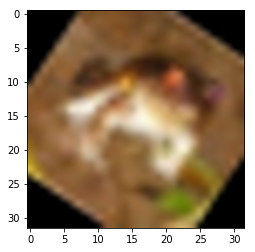

In [40]:
plt.imshow(X_tr[1]/255.,interpolation='spline16')
plt.show()

In [41]:
print(Y_tr[0])
print(Y_tr[1])

6
6


In [42]:
print(X_tr.shape)
print(Y_tr.shape)

(100000, 32, 32, 3)
(100000,)


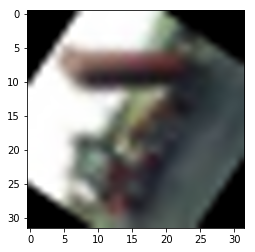

In [43]:
def shuffleData(X_tr, Y_tr):
    perm = np.random.permutation(Y_tr.shape[0])
    X_tr = X_tr[perm,:,:,:]
    Y_tr = Y_tr[perm]
    return X_tr, Y_tr

plt.imshow(X_tr[5]/255, interpolation='spline16')
plt.show()

In [44]:
X_tr, Y_tr = shuffleData(X_tr, Y_tr)

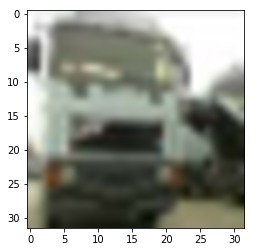

In [45]:
# #Checking if data looks okay after randomly shuffling
# # print(Y_tr[9800])
plt.imshow(X_tr[901]/255, interpolation='spline16')
plt.show()
# # print (Y_tr[9800])
# # print((X_tr))

In [46]:
#Normalization
X_tr -= np.mean(X_tr, axis=0)
X_tr /= np.std(X_tr, axis=0) 

X_te -= np.mean(X_te, axis=0)
X_te /= np.std(X_te, axis=0) 

In [47]:
training_labels = np.zeros((len(Y_tr),10))
testing_labels = np.zeros((len(Y_te),10))
training_labels[np.arange(len(Y_tr)), Y_tr] = 1
testing_labels[np.arange(len(Y_te)), Y_te] = 1
print (Y_tr[5:8])
print(training_labels[5:8])
print(training_labels.shape)

[4 5 3]
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
(100000, 10)


In [48]:
#TENSORFLOW MODEL PARAMETERS

image_size = 32
num_labels = 10
num_imgs = 50000
input_channels = 3
output_nodes = 10

batch_size = 50

channels_K = 8 # First convolutional layer depth
channels_L = 16 # Second convolutional layer depth
channels_M = 32 # Third convolutional layer depth
channels_N = 64 # Fourth convolutional layer depth
channels_O = 128 # Fifth convolutional layer depth
channels_P = 256 # Fifth convolutional layer depth
channels_Q = 512 # Fully connected layer nodes


stride_K = 1 
stride_L = 1
pooling1 = 2
stride_M = 1 
stride_N = 1
pooling2 = 2
stride_O = 1 
pooling3 = 2
stride_P = 1

patch_K = 3
patch_L = 3
patch_M = 3
patch_N = 3
patch_O = 3
patch_P  = 3
patch_Q = int(image_size/(pooling1*pooling2*pooling3*stride_K*stride_L*stride_M*stride_N*stride_O*stride_P))

pkeep_pool1_train, pkeep_pool2_train, pkeep_fc_train = 0.75, 0.75, 0.75 # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.7 at training time
pkeep_pool1_test, pkeep_pool2_test, pkeep_fc_test= 1.0, 1.0, 1.0
num_steps = 10000

lr_start = 0.001 
lr_start_SGD = 0.001
decay_steps = num_steps
decay_rate = 0.95 # for decaying SGD

In [49]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [50]:
#placeholder variables to feed data
graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32,[None, image_size, image_size, input_channels])
    Y_ = tf.placeholder(tf.float32,[None, output_nodes])
    testing_data = tf.constant(X_te.astype(np.float32))
    global_step = tf.Variable(0)

    W1 = tf.Variable(tf.truncated_normal([patch_K,patch_K,input_channels,channels_K],stddev=0.1))
    B1 = tf.Variable(tf.ones([channels_K])/10)

    W2 = tf.Variable(tf.truncated_normal([patch_L,patch_L,channels_K,channels_L],stddev=0.1))
    B2 = tf.Variable(tf.ones([channels_L])/10)

    W3 = tf.Variable(tf.truncated_normal([patch_M,patch_M,channels_L,channels_M],stddev=0.1))
    B3 = tf.Variable(tf.ones([channels_M])/10)
    
    W4 = tf.Variable(tf.truncated_normal([patch_N,patch_N,channels_M,channels_N],stddev=0.1))
    B4 = tf.Variable(tf.ones([channels_N])/10)
    
    W5 = tf.Variable(tf.truncated_normal([patch_O,patch_O,channels_N,channels_O],stddev=0.1))
    B5 = tf.Variable(tf.ones([channels_O])/10)
    
    W6 = tf.Variable(tf.truncated_normal([patch_P,patch_P,channels_O,channels_P],stddev=0.1))
    B6 = tf.Variable(tf.ones([channels_P])/10)

    W7 = tf.Variable(tf.truncated_normal([patch_Q*patch_Q*channels_P,channels_Q],stddev=0.1))
    B7 = tf.Variable(tf.ones([channels_Q])/10)

    W8 = tf.Variable(tf.truncated_normal([channels_Q,output_nodes],stddev=0.1))
    B8 = tf.Variable(tf.ones([output_nodes])/10)

    #TENSORFLOW MODEL DEFINITION
    
    def model(data,pkeep_pool1, pkeep_pool2, pkeep_fc):

        Y1 = tf.nn.relu(tf.nn.conv2d(data,W1,strides = [1,stride_K,stride_K,1],padding='SAME') + B1 )
        Y2 = tf.nn.relu(tf.nn.conv2d(Y1,W2,strides = [1,stride_L,stride_L,1],padding='SAME') + B2 )
        pool1 = tf.nn.max_pool(Y2, [1,pooling1,pooling1,1],[1,pooling1,pooling1,1], padding='SAME')
        pool1 = tf.nn.dropout(pool1, pkeep_pool1)
        
        Y3 = tf.nn.relu(tf.nn.conv2d(pool1,W3,strides = [1,stride_M,stride_M,1],padding='SAME') + B3 )
        Y4 = tf.nn.relu(tf.nn.conv2d(Y3,W4,strides = [1,stride_N,stride_N,1],padding='SAME') + B4 )
        pool2 = tf.nn.max_pool(Y4, [1,pooling2,pooling2,1],[1,pooling2,pooling2,1], padding='SAME')
        pool2 = tf.nn.dropout(pool2, pkeep_pool2)
        print(pool2)
        
        Y5 = tf.nn.relu(tf.nn.conv2d(pool2,W5,strides = [1,stride_O,stride_O,1],padding='SAME') + B5 )
        pool3 = tf.nn.max_pool(Y5,[1,pooling3,pooling3,1],[1,pooling3,pooling3,1], padding='SAME')
        print(pool3)
        
        Y6 = tf.nn.relu(tf.nn.conv2d(pool3,W6,strides=[1,stride_P, stride_P,1], padding='SAME') + B6)
        print(Y6)
        
        YY = tf.reshape(Y6,shape=[-1, patch_Q*patch_Q*channels_P])
        print(YY)

#         Y6 = tf.nn.relu(tf.matmul(YY, W6) + B6)
        Y7 = (tf.matmul(YY, W7) + B7)
        batch_mean, batch_var = tf.nn.moments(Y7,[0])
        offset = tf.Variable(tf.zeros([channels_Q]))
        scale = tf.Variable(tf.ones([channels_Q]))
        epsilon = 1e-3
        Y8 = tf.nn.batch_normalization(Y7,batch_mean,batch_var,offset,scale,epsilon)
        Y8 = tf.nn.dropout(Y8, pkeep_fc) 
        print(Y8)
        return (tf.matmul(Y8,W8) + B8)
    
    logits = model(X,pkeep_pool1_train, pkeep_pool2_train, pkeep_fc_train)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y_, logits = logits))
    optimizer = tf.train.AdamOptimizer(lr_start).minimize(loss, global_step=global_step)
    
#     learning_rate = tf.train.exponential_decay(lr_start_SGD, global_step,num_steps,decay_rate,staircase=True) #changed
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
    
    train_predict = tf.nn.softmax(logits)
    test_predict = tf.nn.softmax(model(testing_data,pkeep_pool1_test, pkeep_pool2_test, pkeep_fc_test))
    
    saver=tf.train.Saver(write_version=tf.train.SaverDef.V2)

print('######## Model Ready ########')

Tensor("dropout_1/mul:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Relu_5:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4096), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 512), dtype=float32)
Tensor("MaxPool_4:0", shape=(10000, 8, 8, 64), dtype=float32)
Tensor("MaxPool_5:0", shape=(10000, 4, 4, 128), dtype=float32)
Tensor("Relu_11:0", shape=(10000, 4, 4, 256), dtype=float32)
Tensor("Reshape_4:0", shape=(10000, 4096), dtype=float32)
Tensor("batchnorm_1/add_1:0", shape=(10000, 512), dtype=float32)
######## Model Ready ########


Minibatch loss at step 10000: 0.944513
Minibatch accuracy: 64.0%
Last test accuracy: 74.2% at step: 9500 | Change: -0.1 | Epoch: 10.0


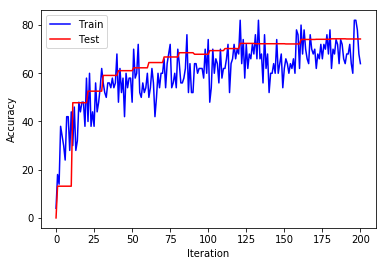

Model saved in file: /media/neeraj/22EA01DAE195164A/Machine Learning/CIFAR/Model_variables_pooling.ckpt 

Iterations complete


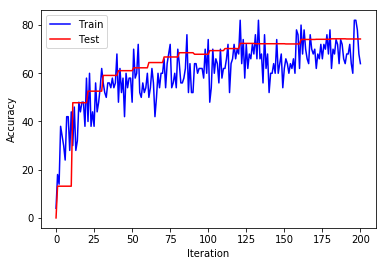

In [51]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Session Started")
    
#     saver.restore(sess, os.path.join(os.getcwd(), 'Model_variables_pooling.ckpt')) #reads saved checkpoint
    print('Model_variables read')
    
    train_accuracy_plot, test_accuracy_plot,step_plot = [], [], []
    test_accuracy,last_test_accuracy, change, last_step = 0,0,0,0
        
    for step in range(num_steps+1):
        offset = step*batch_size % (training_labels.shape[0] - batch_size)
        batch_data = X_tr[offset:(offset+batch_size), : , : , :]
        batch_labels = training_labels[offset:(offset+batch_size),:]
        
        fdict = {X:batch_data, Y_:batch_labels}
        _ , l, predictions = sess.run([optimizer, loss, train_predict], feed_dict=fdict)
        
        if step % 50 == 0:
            train_accuracy = accuracy(predictions, batch_labels)
            
            display.clear_output(wait=True)
            print('Minibatch loss at step %d: %g' % (step, l))
            print('Minibatch accuracy: %.1f%%' %train_accuracy )
            print('Last test accuracy: %.1f%% at step: %s | Change: %.1f | Epoch: %.1f' % (test_accuracy, last_step, change,step*batch_size/num_imgs))

            
            train_accuracy_plot.append(train_accuracy) 
            test_accuracy_plot.append(test_accuracy)
            step_plot.append(step/100)    
            
            pl.clf()
            pl.xlabel('Iteration')
            pl.ylabel('Accuracy')
            pl.plot(train_accuracy_plot, '-b', label='Train')
            pl.plot(test_accuracy_plot, '-r', label='Test')
            pl.legend(loc='upper left')
            display.display(pl.gcf())            
            
        if step % 500 == 0:            
            test_accuracy = accuracy(test_predict.eval(), testing_labels)
            change = test_accuracy - last_test_accuracy 
            last_test_accuracy = test_accuracy
            last_step = step

    save_path= saver.save(sess, os.path.join(os.getcwd(), 'Model_variables_pooling.ckpt'))   #creates checkpoint
    print ("Model saved in file: %s \n" %save_path)
    print('Iterations complete')

In [52]:
test_accuracy

75.319999999999993